In [1]:
import os
os.chdir('../src')

In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics, cross_decomposition, model_selection
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

import technical
import talib

In [3]:
keys = ['timestamp','open','high','low','close','volume','TakerBuyQuoteAssetVolume',
                                   'TakerBuyBaseAssetVolume','QuoteAssetVolume','trades']
df = pd.read_csv("../data/cryptoarchive/ETHBTC_1m.csv", sep='|', header=None,
                            names=keys)

In [94]:
target_interval = 30
df['target'] = pd.Series(np.log(df.close)).diff(target_interval).shift(-target_interval)

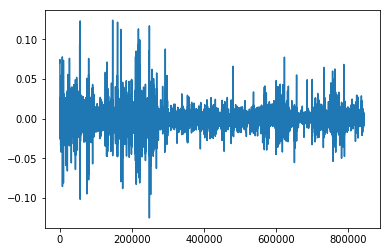

In [95]:
df.target.plot()

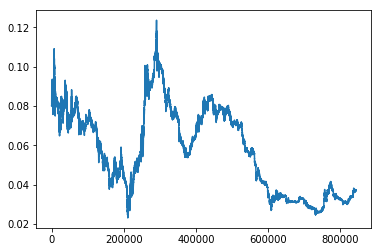

In [96]:
df.close.plot()

# Cumulative volatility & volume

Cumulative volatility & volume might be a very good and precise way to visualize it, without the need of moving averages.

### Binance

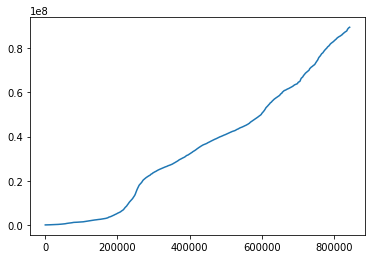

In [103]:
df['std'] = np.square(df.target)
df.volume.cumsum().plot()

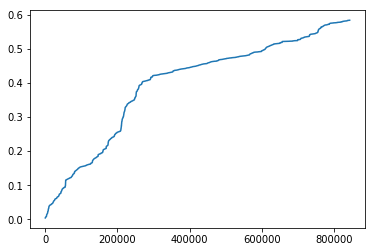

In [105]:
df.std[::30].cumsum().plot()

### Poloniex

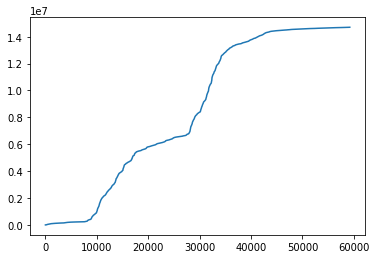

In [102]:
poloniex = pd.read_json('../data/raw/BTC_ETH.json')
poloniex.volume.cumsum().plot()

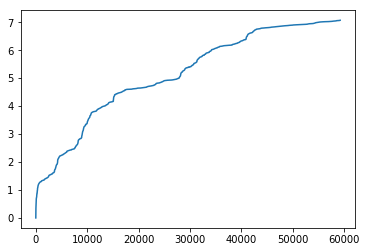

In [111]:
poloniex['target'] = pd.Series(np.log(poloniex.close)).diff().shift(-1)
poloniex['std'] = np.square(poloniex.target)
poloniex['std'].cumsum().plot()

## Overlaps

Let's compare the two exchanges' data.

In [106]:
fst, last = pd.Timestamp.fromtimestamp(df.timestamp[0]), pd.Timestamp.fromtimestamp(df.timestamp.iloc[-1])
overlap_dates = poloniex.date[(poloniex.date > fst) * (poloniex.date < last)]
print(overlap_dates.iloc[0], overlap_dates.iloc[-1])
fst, last = overlap_dates.index[0], overlap_dates.index[-1]
fst, last

2017-07-14 06:30:00 2018-12-23 19:30:00


/home/adrian/.conda/envs/ml/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(33891, 59213)

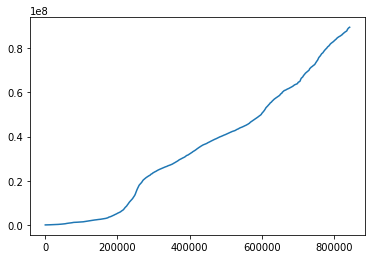

In [107]:
df.volume.cumsum().plot()

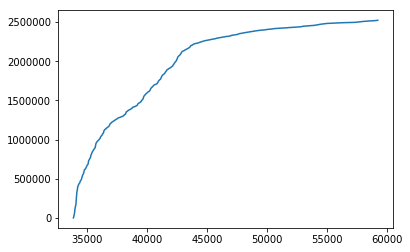

In [108]:
poloniex.volume[fst:last].cumsum().plot()

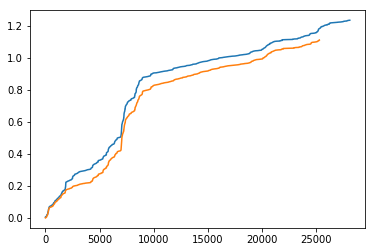

In [115]:
df[::30].reset_index()['std'].cumsum().plot()
poloniex[fst:last].reset_index()['std'].cumsum().plot()

As one might have expected, the volatility is pretty much exchange-invariant, though when binance started trading, the volatility was bigger than on poloniex.

# Normalizing

To account for exchange popularity fluctuations, I want to use volume share data. Actually, I think it would be to bothersome to get the data, since then you see news like [this one](https://www.ccn.com/major-bitcoin-exchanges-accused-of-faking-volume-whos-trustworthy). Furthermore volatility based scaling does make much more sense statistically.



In [3]:
keys = ['timestamp','open','high','low','close','volume','TakerBuyQuoteAssetVolume',
                                   'TakerBuyBaseAssetVolume','QuoteAssetVolume','trades']
df = pd.read_csv("../data/cryptoarchive/ETHBTC_1m.csv", sep='|', header=None,
                            names=keys)
df['target'] = pd.Series(np.log(df.close)).diff().shift(-1)
df['std'] = np.square(df.target)
df['std_cum'] = df['std'].cumsum()

In [4]:
df.std_cum.iloc[-2] / len(df) * 10 # timesteps corresponding to 10 minutes

1.961835447537818e-05

In [5]:
vol = pd.read_hdf('../data/features/volatility_scaled.h5')

**Here is my glorious volatility scaling:**(and the original timeseries below for reference)

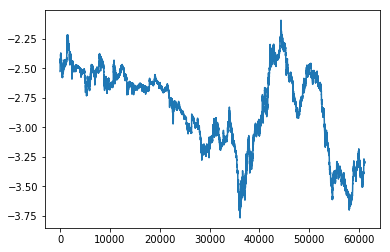

In [18]:
vol = vol.reset_index()
pd.Series(np.log(vol.close)).plot()

In [190]:
pd.Series(np.log(df.close)).plot()

In [8]:
vol['target'] = pd.Series(np.log(vol.close)).diff().shift(-1)

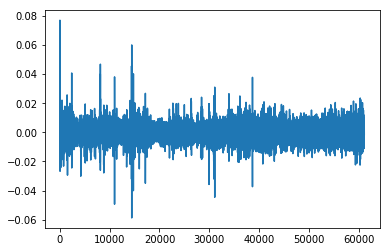

In [22]:
vol.target.plot()

So beautiful & natural! I'm so proud of it!

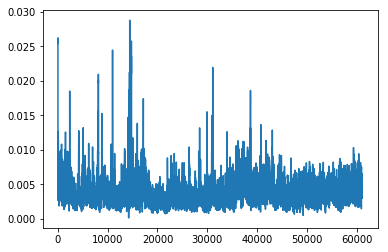

In [21]:
vol.target.rolling(10).std().plot()

In [23]:
df.target.rolling(10).std().plot()

Though the tails are definetly not the same. Definetly some kurtosis change going on here.

In [30]:
np.sum(np.power([1,2,3], 4))

98

/home/adrian/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


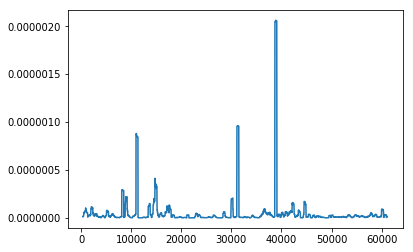

In [13]:
vol.target[::20].rolling(20).apply(lambda w: np.sum(np.power(w, 4))).plot()

/home/adrian/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


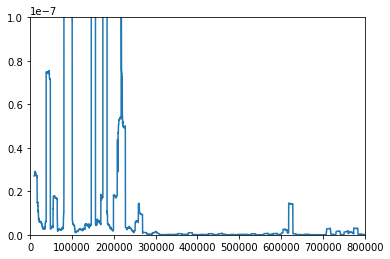

In [6]:
ax = plt.gca(xlim=(1, 800000), ylim=(0, 1e-7))
df.target[::100].rolling(100).apply(lambda w: np.sum(np.power(w, 4))).plot()

The kurtoisis doesn't seem very bad - the time scaled series was much worse.

In [16]:
import seaborn as sns
g = sns.kdeplot(vol.target)

We still have tails as fat as ever :)

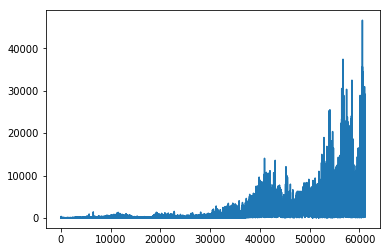

In [22]:
vol.volume.plot()


-> Data will have much bigger accuracy at the end. We already saw the discrepancy in volatility between poloniex & binance.

Now what is really the price movement per minutely volatility? This measure shows whether the market actually moved per unit volatility, or if it just oscillated.

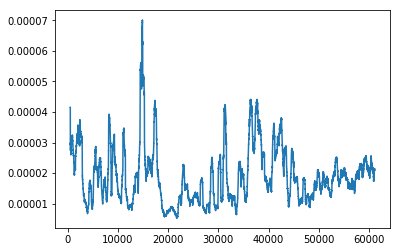

In [28]:
pd.Series(np.square(vol.target)).rolling(500).mean().plot()

In [78]:
tenpercentlife = 10
alpha = math.pow(0.1, 1 / tenpercentlife)
import math
filter_length = 100
ema = list(map(lambda n: (1 - alpha) * math.pow(alpha, n), range(filter_length)))
vol['discounted'] = np.concatenate((np.convolve(ema, vol.target, mode='valid'), np.full(filter_length - 1, np.nan)))

In [79]:
alpha

0.7943282347242815

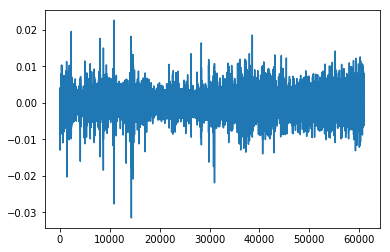

In [51]:
vol.discounted.plot()

This messes up the normalized std, especially for slow discounts :(